<a href="https://colab.research.google.com/github/conorlime/CS6271/blob/main/DEAP_Algorithms_(GP_Symbolic_Regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GP Toolbox for DEAP

Here we use DEAP to implement GP. This notebook is based on the *DEAP Algorithms (GA)* notebook we used earlier and only does a **single** run to keep thing simple.

GP is a lot more complex than GA so we will import more packages and do a bit more housekeeping before we run out algorithm.

Install DEAP. 

In [ ]:
!pip install deap

Import the DEAP tools and useful libraries . Notice this time we have some extra ones because of the symbolic nature of GP.

In [4]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


import matplotlib.pyplot as plt

Set our Genetic Programming parameters.  Notice that these are virtually the same as the GA ones.

In [5]:
# Genetic Programming constants:
POPULATION_SIZE = 5
P_CROSSOVER = 0.7  # probability for crossover
P_MUTATION = 0.01   # probability for mutating an individual
MAX_GENERATIONS = 10
HALL_OF_FAME_SIZE = 10


Set the random seed. 

In [6]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

Because GP can mix and match operators and operands in an unconstrained way, we need to protect some our operators to prevent them from causing a crash.

In [7]:
# Define new functions
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

Add our functions and terminals.

In [8]:
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.renameArguments(ARG0='x')

Define our fitness function. This one is a bit more involved than early examples for the GA, as we need to calculate the error. In this case we want to compare the returned (predicted) values from an individual compared to what **should** have been returned. If the error is huge (defined as > 1000 here), we put a ceiling of 1000 on it.


In [9]:
def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    sqerrors = ((func(x) - x**6 - x**5 - x**4 - x**3 - x**2 - x)**2 for x in points)
    #sqerrors = ((func(x) - x - 23)**2 for x in points)
    myError = math.fsum(sqerrors) / len(points)
    if myError>1000:
       myError=1000
    return myError,

Create our toolbox. We have a number of key differences here, so pay attention to the following:

* In this case (and usually with Symbolic Regression in GP) we are looking to **minimize** error
* Our individuals are **trees** rather than lists
* Some operators, e.g. mutation, operate differently for GP so take them from the gp package


In [10]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-5,5)])
toolbox.register("select", tools.selTournament, tournsize=5)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=5)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))


Set up our population as before

In [11]:
population = toolbox.population(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)   


Create a statistics object. This time we're going to use the **MultiStatistics** tool because we want to record statistics about **size** as well as **fitness**.

In [12]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

Let's run our GP -- notice how it's almost the same as running the GA.

In [13]:
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                               ngen=MAX_GENERATIONS, stats=mstats,
                               halloffame=hof, verbose=True)

   	      	                        fitness                         	                      size                     
   	      	--------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max   	min      	nevals	std     	avg	gen	max	min	nevals	std    
0  	5     	0.50714	0  	1.0272	0.0998331	5     	0.363206	4  	0  	7  	2  	5     	2.09762
1  	4     	0.122622	1  	0.213776	0.0998331	4     	0.0455773	3.6	1  	6  	3  	4     	1.2    
2  	2     	0.0998331	2  	0.0998331	0.0998331	2     	0        	3  	2  	3  	3  	2     	0      
3  	4     	0.0998331	3  	0.0998331	0.0998331	4     	0        	3  	3  	3  	3  	4     	0      
4  	2     	0.0998331	4  	0.0998331	0.0998331	2     	0        	3  	4  	3  	3  	2     	0      
5  	0     	0.0998331	5  	0.0998331	0.0998331	0     	0        	3  	5  	3  	3  	0     	0      
6  	2     	0.0998331	6  	0.0998331	0.0998331	2     	0        	3  	6  	3  	3  	2     	0      
7  	4     	0.0998331	7  	0.0998331	0.0

Extract our statistcs. This time our logbook has *chapters* because we have maintained multiple statistics.

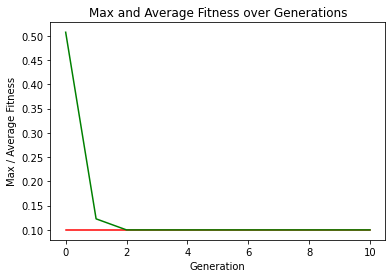

In [14]:
maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

Not much evolution going on here for the max fitness, but that's okay as this is an easy problem. What's important is that we can see that the average fitness decreases quickly too.